In [1]:
import sys; sys.path.insert(0,'../')
from dist_tools import *

from IPython.display import display
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000

usps, seats, fips, epsg = "WI", 8, 55, 3695

%matplotlib inline

In [2]:
wif = "/media/jsaxon/brobdingnag/data/el_dv/wi_site/"
map_04 = gpd.read_file(wif + "2004/wtm_8391_wards_2004_ed.shp")
map_04.rename(columns = {"PRES_DEM" : "D04", "PRES_REP" : "R04"}, inplace = True)
map_04 = map_04[["D04", "R04", "geometry"]]
map_04["DFrac"] = map_04.D04 / (map_04.D04 + map_04.R04)
map_04 = map_04.to_crs(epsg = epsg)

map_08 = gpd.read_file(wif + "2008/2008_Election_Data_By_Ward.shp")
map_08.rename(columns = {"PRESDEM08" : "D08", "PRESREP08" : "R08"}, inplace = True)
map_08 = map_08[["D08", "R08", "geometry"]]
map_08["DFrac"] = map_08.D08 / (map_08.D08 + map_08.R08)
map_08 = map_08.to_crs(epsg = epsg)

map_12 = gpd.read_file(wif + "2012/Wards_111312_ED_110612.shp")
map_12.rename(columns = {"PRES_DEM12" : "D12", "PRES_REP12" : "R12"}, inplace = True)
map_12 = map_12[["D12", "R12", "geometry"]]
map_12["DFrac"] = map_12.D12 / (map_12.D12 + map_12.R12)
map_12 = map_12.to_crs(epsg = epsg)

map_16 = gpd.read_file(wif + "2016/Wards2017_ED12toED16.shp")
map_16.rename(columns = {"PREDEM16" : "D16", "PREREP16" : "R16"}, inplace = True)
map_16 = map_16[["D16", "R16", "geometry"]]
map_16["DFrac"] = map_16.D16 / (map_16.D16 + map_16.R16)
map_16 = map_16.to_crs(epsg = epsg)

In [3]:
output_geojson(map_04.set_geometry(map_04.geometry.simplify(10)), 
               var = "DFrac", fname = "mapped/wi_2004.geojson")

output_geojson(map_08.set_geometry(map_08.geometry.simplify(10)), 
               var = "DFrac", fname = "mapped/wi_2008.geojson")

output_geojson(map_12.set_geometry(map_12.geometry.simplify(10)), 
               var = "DFrac", fname = "mapped/wi_2012.geojson")

output_geojson(map_16.set_geometry(map_16.geometry.simplify(10)), 
               var = "DFrac", fname = "mapped/wi_2016.geojson")

In [4]:
tr_rn = get_tr_rn(usps).to_crs(epsg = epsg)

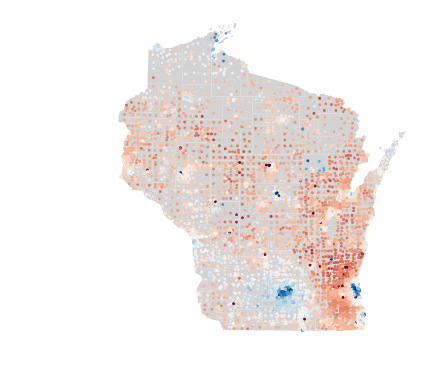

In [5]:
ax = tr_rn.plot(color = "lightgrey", figsize = (3, 3))
map_16.set_geometry(map_16.centroid)\
      .plot(column = "DFrac", cmap = "RdBu", vmin = 0, vmax = 1, markersize = 1, ax = ax)
ax.set_axis_off()

In [6]:
votes04 = merge_tract_number(tr_rn, map_04)
votes08 = merge_tract_number(tr_rn, map_08)
votes12 = merge_tract_number(tr_rn, map_12)
votes16 = merge_tract_number(tr_rn, map_16)

In [7]:
wi_votes = pd.concat([votes04, votes08, votes12, votes16], axis = 1).fillna(0).astype(int)
wi_votes.to_csv("votes/wi.csv")

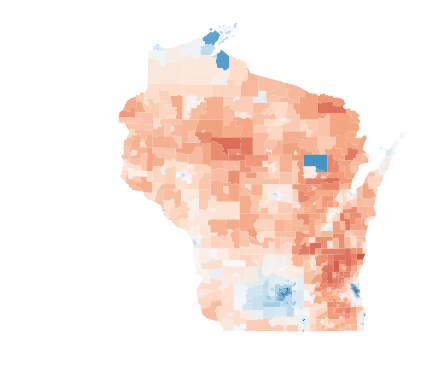

In [8]:
map_sanity_check("wi", 2016, epsg)

In [9]:
bg_rn = get_bg_rn(usps).to_crs(epsg = epsg)

votes04 = merge_tract_number(bg_rn, map_04)
votes08 = merge_tract_number(bg_rn, map_08)
votes12 = merge_tract_number(bg_rn, map_12)
votes16 = merge_tract_number(bg_rn, map_16)

wi_votes = pd.concat([votes04, votes08, votes12, votes16], axis = 1).fillna(0).astype(int)
wi_votes.to_csv("votes/wi_bgroup.csv")
pd.read_csv("votes/wi_bgroup.csv").head()

,rn,D04,R04,D08,R08,D12,R12,D16,R16
0,0,416,524,437,489,228,324,167,360
1,1,157,186,162,166,151,187,132,215
2,2,330,392,355,360,497,616,434,710
3,3,489,404,513,327,434,355,284,480
4,4,178,143,183,100,332,252,226,349
